# Notebook to analyse integrated xenopus scRNA-seq datasets

## Imports

In [31]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import scvelo as scv
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony 
import random
np.random.seed(0)
random.seed(0)

In [2]:
from IntegratedAnalysis import plot_gene_expression

## Settings

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


In [5]:
#scv.logging.print_versions()

# Load data

In [6]:

def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

### Harmony discrete timeseries alignment

In [8]:
import sys
sys.path.append('../Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

In [9]:
timepoints = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , timepoints)
counts = concat_for_harmony(adatas, timepoints)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])




st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [10]:
#Make cluster colorsfor integrated dataset
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [11]:


sns.palplot(colors.sort_values('clust_order').color)

In [12]:
spring = pd.read_csv('../embeddings/SPRING_integrated_coordinates.txt', header = None, index_col = 0)
spring.columns = ['x', 'y']
spring.index = counts.index

In [13]:

tp = pd.Series(index=data_df.index)
for t in timepoints:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [14]:
#Search by gene id
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}\.[S|L]'.format(gene))])

## Run Palantir

In [15]:
with open('../intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [16]:
with open('../intermediate_files/presult', "rb") as f:
    pr_res = pickle.load( f)

In [17]:
#cyto = pd.read_csv('/work/Xenopus/Notebooks/V2/cytotrace/data_cyto/CytoTRACE_plot_table.txt', sep = '\t')

In [18]:
#Load affinity matrix
with open('../V3/intermediate_files/aug_aff', "rb") as f:
    aug_aff = pickle.load( f)

In [19]:
#Diffusion maps for palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff,n_components=20,
    knn=20)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [20]:
#Magic imputation
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

In [21]:
from IntegratedAnalysis import plot_cell_clusters, plot_comp_clusters

In [22]:
#Setup colormap for stages
cluster_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])

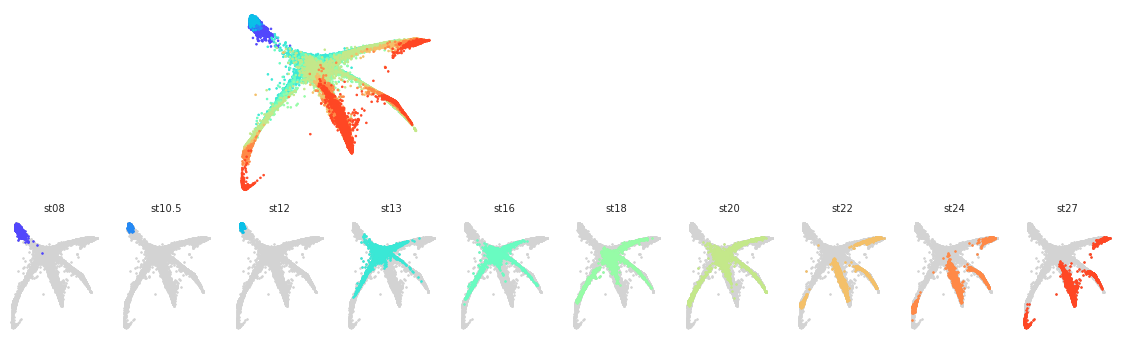

In [32]:

plot_cell_clusters(spring, tp, cluster_colors=cluster_colors, cluster_order = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])


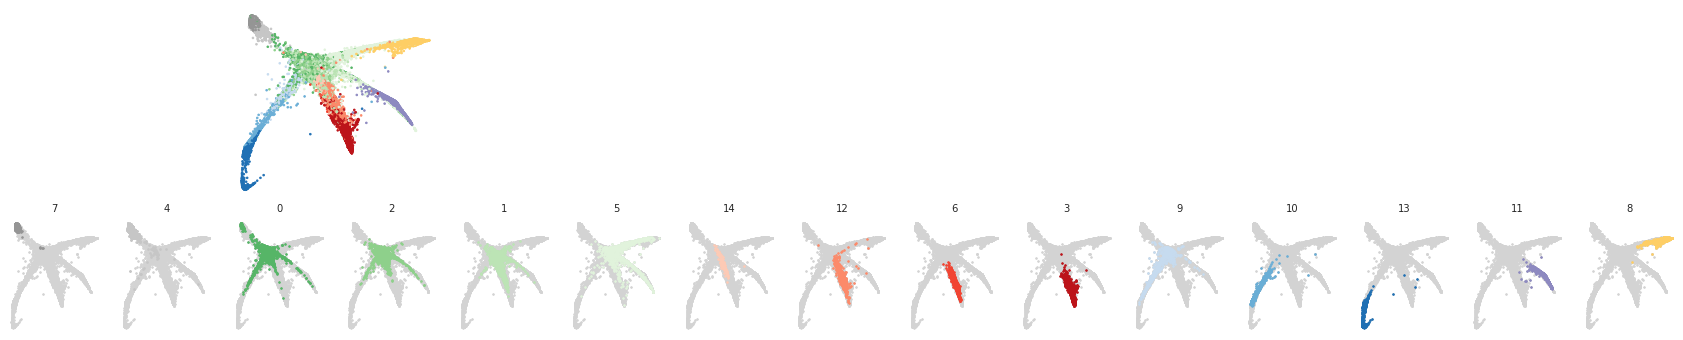

In [31]:
plot_cell_clusters(spring, clusters, cluster_colors=colors.color, cluster_order=colors.sort_values('clust_order').org_clust)


## Finding cell type markers

In [34]:
merge = sc.AnnData(counts)

In [35]:
merge.obs['cluster'] = [str(x) for x in clusters.values]

In [36]:
#Standard scanpy processing
sc.pp.filter_genes(merge, min_cells=1, inplace = True)
sc.pp.normalize_per_cell(merge, counts_per_cell_after=1e4)
sc.pp.log1p(merge)

merge.raw = merge
sc.pp.highly_variable_genes(merge, min_mean=0.0125, max_mean=3, min_disp=0.5)
#merge = merge[:, merge.var.highly_variable]
sc.pp.scale(merge, max_value=10)



In [37]:
merge

AnnData object with n_obs × n_vars = 33990 × 18327 
    obs: 'cluster', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [115]:
#Subset to highly variable genes
merge = merge[:, merge.var.highly_variable]

In [63]:
sc.pp.neighbors(merge, n_neighbors = 50)
sc.tl.louvain(merge, resolution=0.05)

In [65]:
sc.tl.rank_genes_groups(merge, 'cluster', method='t-test', n_genes=len(merge.obs_names))

... storing 'cluster' as categorical


In [120]:
for cluster in range(0, 15):
    df = pd.DataFrame({'Gene':pd.DataFrame(merge.uns['rank_genes_groups']['names']).iloc[0:, cluster],
             'P-adjust':pd.DataFrame(merge.uns['rank_genes_groups']['pvals_adj']).iloc[0:,cluster],
             'logFC':pd.DataFrame(merge.uns['rank_genes_groups']['logfoldchanges']).iloc[0:,cluster]})
    df.Gene = [x.split('|')[1] for x in df.Gene]
    df.to_csv('Cluster_marker_genes_t-test/Cluster_{}_marker_genes.tsv'.format(cluster), sep = '\t')

In [88]:
DE_genes = {}
for cluster in range(0,15):
    df = pd.read_csv('Cluster_marker_genes_t-test/Cluster_{}_marker_genes.tsv'.format(cluster), sep = '\t', index_col = 0)
    DE_genes[cluster] = df[(df['P-adjust'] < 0.05) & (df['logFC'] > 1)].Gene.tolist()

In [23]:
def find(gene):

    return list(counts.columns[counts.columns.str.match(r'^(gene[0-9]+\|){}\.[S|L]'.format(gene))])

# Subclustering

In [24]:
def process_subsets(data, clusters,  clust_subset):
    clusters = clusters[clusters.isin(clust_subset)]
    sub = data.loc[clusters.index,:].copy()
    return sub, clusters

In [25]:
#, coordinates_path, genes

In [26]:
basal_sub, basal_clust = process_subsets(counts, clusters, [14, 12, 6, 3])


In [27]:
def prep_coord(path, row_names):
    spring = pd.read_csv(path, header = None, index_col = 0)
    spring.columns = ['x', 'y']
    spring.index = row_names
    return spring
    
basal_coord = prep_coord('../embeddings/Subcluster_coordinates/Basal_coordinates.txt', basal_sub.index)


basal_projected_coord = prep_coord('../embeddings/Subcluster_coordinates/Basal_projected.txt', basal_sub.index)





In [28]:
from IntegratedAnalysis import plot_gene_expression

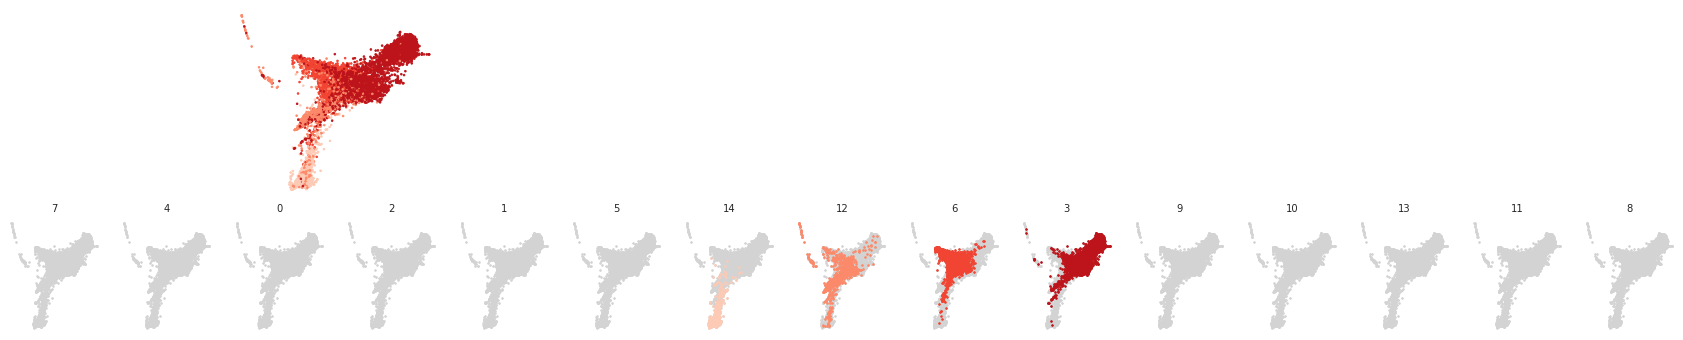

In [32]:
plot_cell_clusters(basal_projected_coord, basal_clust, cluster_colors=colors.color, cluster_order=colors.sort_values('clust_order').org_clust)
#plt.savefig('../intermediate_files/Figures/basal_subset_clusters.pdf',dpi = 500 )

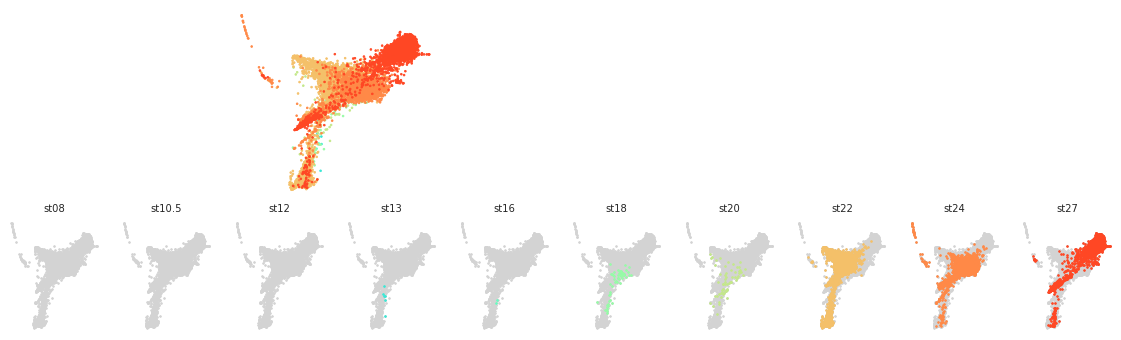

In [33]:
cluster_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])

plot_cell_clusters(basal_projected_coord, tp.loc[basal_coord.index], cluster_colors=cluster_colors, cluster_order = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])
#plt.savefig('../intermediate_files/Figures/basal_subset_stages.pdf',dpi = 500 )

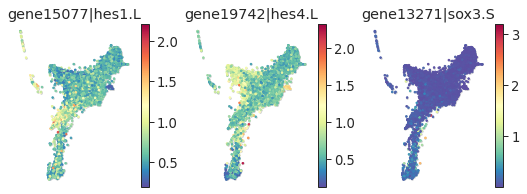

In [51]:
plot_gene_expression(imp_df, basal_projected_coord, 
                                       ['gene15077|hes1.L', 'gene19742|hes4.L',
                                           'gene13271|sox3.S'],
                                       plot_scale=True)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


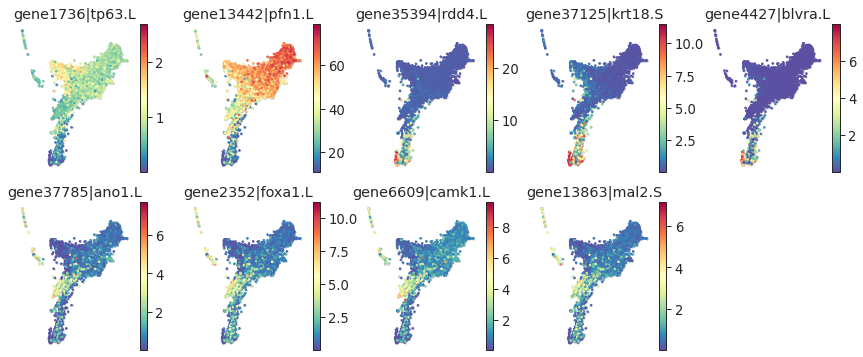

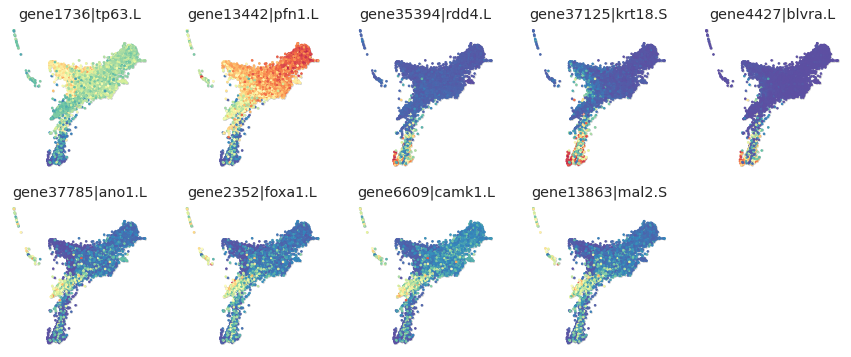

In [42]:
plot_gene_expression(imp_df, basal_projected_coord, 
                                       [
                                       'gene1736|tp63.L', 'gene13442|pfn1.L', 'gene35394|rdd4.L' ,'gene37125|krt18.S', 'gene4427|blvra.L', 
                                        'gene37785|ano1.L','gene2352|foxa1.L','gene6609|camk1.L', 'gene13863|mal2.S'],
                                       plot_scale=True)
#plt.savefig('./intermediate_files/Figures/stem_and_SCC_subset_DE_genes_Scale.pdf',dpi = 500 )
plot_gene_expression(imp_df, basal_projected_coord, [
                                       'gene1736|tp63.L', 'gene13442|pfn1.L', 'gene35394|rdd4.L' ,'gene37125|krt18.S', 'gene4427|blvra.L', 
                                        'gene37785|ano1.L','gene2352|foxa1.L','gene6609|camk1.L', 'gene13863|mal2.S'],
                                       plot_scale=False)
#plt.savefig('./intermediate_files/Figures/stem_and_SCC_subset_DE_genes_NoScale.pdf',dpi = 500 )

In [106]:
ann = pd.read_csv('/work/Xenopus/Notebooks/V3/Sup_tables/Metadata.tsv', sep = '\t', index_col = 0)

In [109]:
test = ann.groupby(['Phenograph Clusters', 'Cell Cycle Phase']).count().reset_index()
test = pd.pivot(test, 'Phenograph Clusters', 'Cell Cycle Phase', 'Per Stage Louvain')

In [110]:
test = test.div(test.sum(axis = 1), axis = 0) * 100

In [111]:
test = test.iloc[[14, 12, 6, 3]]

In [114]:
color=['#c6c6c6', '#bc141a','#2070b4']
order = ['G1', 'S', 'G2M']

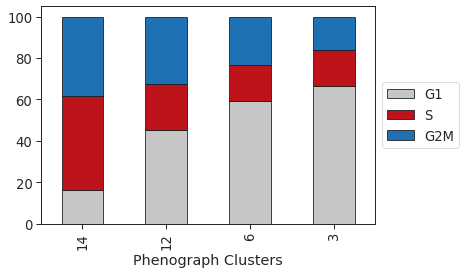

In [117]:
test.loc[:,order].plot.bar(stacked=True, color = color, edgecolor='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [43]:
merge = sc.AnnData(basal_sub)

In [57]:
merge.obs['cluster'] = basal_clust.map(str)

In [49]:
#Standard scanpy processing
sc.pp.filter_genes(merge, min_cells=1, inplace = True)
sc.pp.normalize_per_cell(merge, counts_per_cell_after=1e4)
sc.pp.log1p(merge)

merge.raw = merge
sc.pp.highly_variable_genes(merge, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(merge, max_value=10)



In [50]:
merge

AnnData object with n_obs × n_vars = 7601 × 16959
    obs: 'Cluster', 'cluster', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [51]:
#Subset to highly variable genes
merge = merge[:, merge.var.highly_variable]

In [53]:
sc.pp.neighbors(merge, n_neighbors = 50)

In [56]:
merge.obs

,Cluster,cluster,n_counts
st13_AACGTTGAGCTATGCT,14,14,310.0
st13_ACCGTAAAGATATGCA,14,14,229.0
st13_CTCACACTCGGCGGTT,14,14,209.0
st13_CTTCTCTGTGGCTCCA,14,14,235.0
st13_GGACAGACACAGTCGC,14,14,224.0
...,...,...,...
st27_TTTGGTTTCAGATAAG,3,3,639.0
st27_TTTGGTTTCTTTAGGG,3,3,534.0
st27_TTTCCTCAGAAGGTGA,3,3,640.0
st27_TTTGCGCAGAGTGACC,3,3,591.0


In [58]:
sc.tl.rank_genes_groups(merge, 'cluster', method='t-test')#, n_genes=len(merge.obs_names))

... storing 'cluster' as categorical


In [60]:
pd.DataFrame(merge.uns['rank_genes_groups']['names']).head(10)

,3,6,12,14
0,gene555|tmsb4x.L,gene18372|rpl7a.L,gene2352|foxa1.L,gene12761|hnrnpab.S
1,gene2998|LOC108709292,gene18340|hspa8.S,gene37785|ano1.L,gene37125|krt18.S
2,gene888|zc3h10.S,gene15886|eppk1.L,gene6609|camk1.L,gene8910|rplp0.L
3,gene19768|fbp1.L,gene477|calr,gene13863|mal2.S,gene11052|ncl.S
4,gene14175|ftmt.S,gene6846|rplp2.L,gene18797|gnb3.L,gene6846|rplp2.L
5,gene9991|krt5.7.S,gene5419|rpl7a.S,gene14901|kcna4.S,gene8191|prmt1.S
6,gene38919|LOC108709680,gene38576|szl.L,gene7310|tmem263.L,gene18372|rpl7a.L
7,gene11535|LOC108717861,gene17910|hspa8.L,gene9991|krt5.7.S,gene11772|LOC108697670
8,gene3584|krt5.7.L,gene2750|pabpc1.S,gene3081|hmgb2.S,gene36329|LOC108716102
9,gene1309|LOC108699649,gene3904|hsp90ab1.S,gene13000|foxa1.S,gene35394|rdd4.L


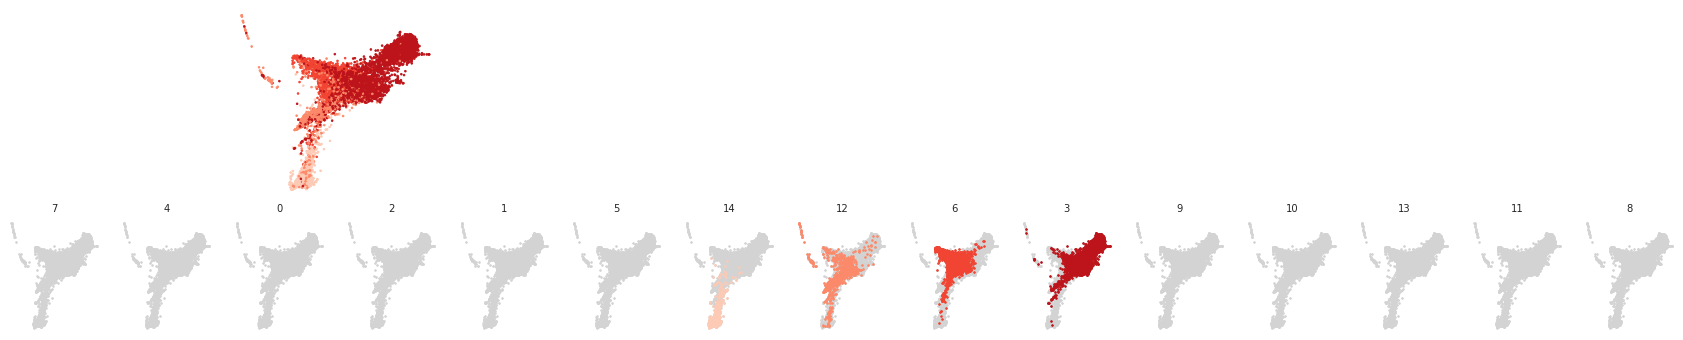

In [64]:
plot_cell_clusters(basal_projected_coord, basal_clust, cluster_colors=colors.color, cluster_order=colors.sort_values('clust_order').org_clust)


In [94]:
genes = pd.DataFrame(merge.uns['rank_genes_groups']['names']).head(20)['3']

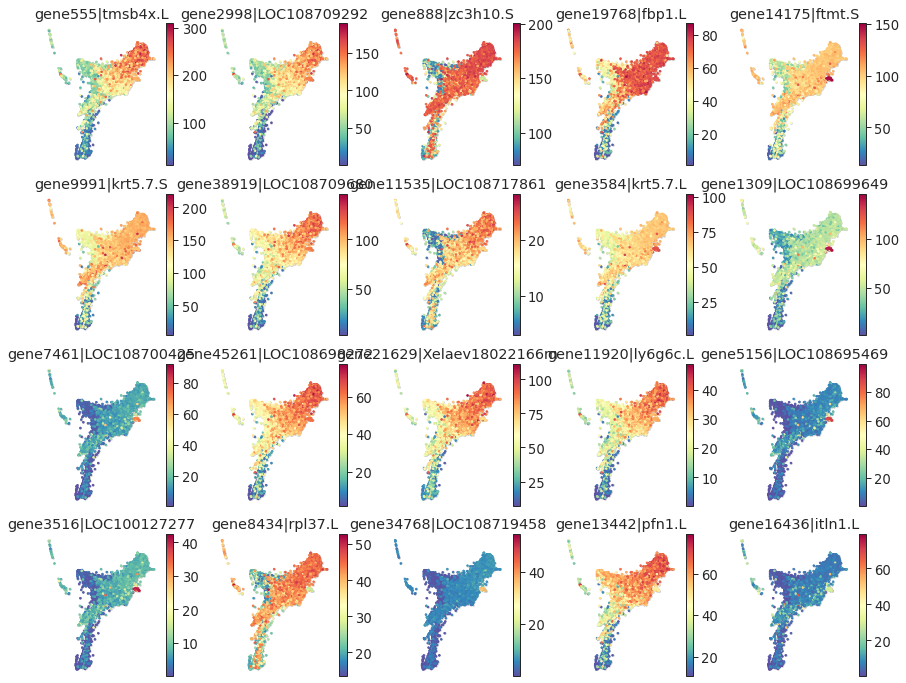

In [95]:
plot_gene_expression(imp_df, basal_projected_coord, genes,
                                       plot_scale=True)

In [113]:
genes = pd.DataFrame(merge.uns['rank_genes_groups']['names']).head(20)['6']

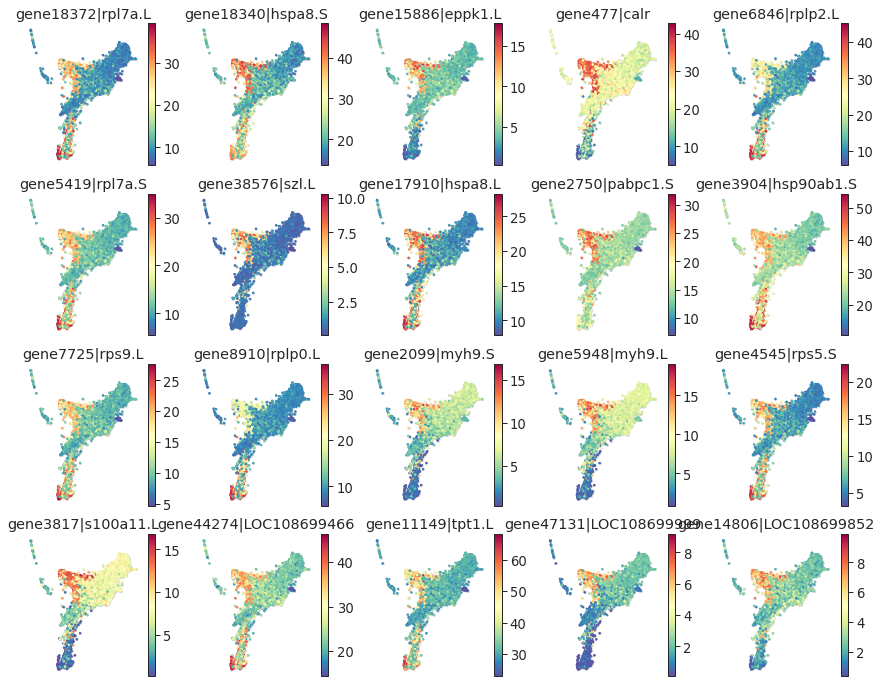

In [118]:
plot_gene_expression(imp_df, basal_projected_coord, genes,
                                       plot_scale=True)

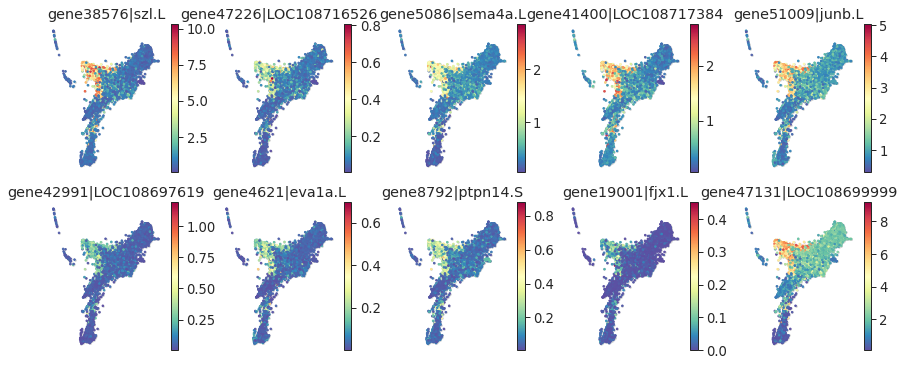

In [142]:

plot_gene_expression(imp_df, basal_projected_coord, co.sort_values(ascending = False)[:10].index,
                                       plot_scale=True)

In [110]:
genes = pd.DataFrame(merge.uns['rank_genes_groups']['names']).head(20)['12']

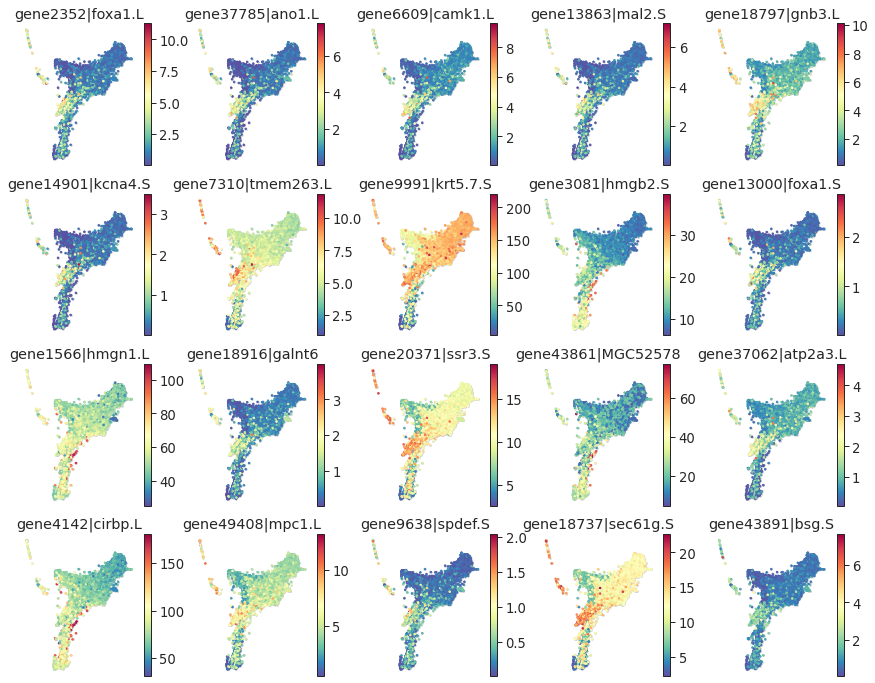

In [112]:
plot_gene_expression(imp_df, basal_projected_coord, genes,
                                       plot_scale=True)

In [100]:
genes = pd.DataFrame(merge.uns['rank_genes_groups']['names']).head(20)['14']

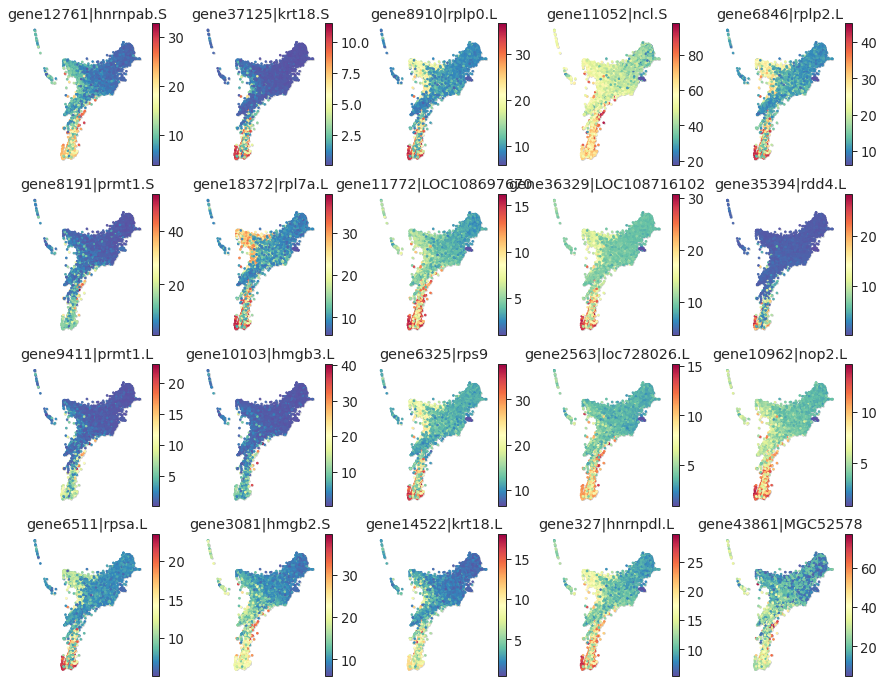

In [101]:
plot_gene_expression(imp_df, basal_projected_coord, genes,
                                       plot_scale=True)